# 🔍 Sensitivity and Calibration Analysis of Diabetes Prediction Models

This notebook aims to evaluate the robustness and reliability of predictive models for diabetes using data from the ENSIN 2005 survey. Given the limitations of the dataset such as class imbalance

In [8]:

import pandas as pd

## Load raw datasets from  input directory.
## Note: NutrientsDataset uses comma as decimal separator, so we set decimal=",".
try:
    EN2005a = pd.read_csv(
        "FoodDataset.csv", ## Change the path
        delimiter=";",
        low_memory=False,
        encoding="utf-8",
        on_bad_lines="warn"  # prevent failure on malformed rows
    )
    EN2005c = pd.read_csv(
        "NutrientsDataset.csv", ## Change the path
        delimiter=";",
        decimal=",",
        low_memory=False,
        encoding="latin1",
        on_bad_lines="warn"
    )
    print("Files loaded successfully.")
except FileNotFoundError as e:
    ## Explicit error message for debugging if filenames or paths change
    print("One or more input files were not found:", e)
    raise

## Data cleaning step: drop the second column of EN2005c if it exists
if EN2005c.shape[1] > 1:
    EN2005c = EN2005c.drop(EN2005c.columns[0], axis=1)

## Optional: remove trailing spaces from column names to avoid merge issues later
EN2005a.columns = EN2005a.columns.str.strip()
EN2005c.columns = EN2005c.columns.str.strip()

import pandas as pd

## Remove specific columns after evaluating high correlation with other variables
columns_to_drop = [
    "Calcium %RDA", "Folic Acid %RDA", "Vitamin A %RDA", "Vitamin C %RDA",
    "Vitamin B12 %RDA", "Fiber %RDA", "Zinc %RDA", "Protein %RDA", "Fat (g)"
]

EN2005c = EN2005c.drop(columns=columns_to_drop)
print("Highly correlated variables removed.")


Files loaded successfully.
Highly correlated variables removed.


In [9]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1 

In [10]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # needed to enable IterativeImputer
from sklearn.impute import IterativeImputer

## Impute missing values using IterativeImputer (multivariate approach)
imputer = IterativeImputer() # random
EN2005c = pd.DataFrame(imputer.fit_transform(EN2005c), columns=EN2005c.columns)

print("Missing values imputed successfully.")

from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

## Split features and target (assumes 'Diabetes' is the target column)
X = EN2005a.drop('Diabetes', axis=1)
y = EN2005a['Diabetes']

## Check original class distribution
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
print("Original class distribution:", class_counts.to_dict())

## Define SMOTE cap: minority class will not exceed 400% of its original size
max_minority_samples = int(class_counts[minority_class] * 4)

## SMOTE sampling strategy (only the minority class is increased)
sampling_strategy = {
    majority_class: class_counts[majority_class],
    minority_class: max_minority_samples
}

## Use a safe k_neighbors in case the minority class is very small
k_neighbors_safe = max(1, min(5, class_counts[minority_class] - 1))

## Apply SMOTE oversampling
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors_safe, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_resampled))

## Temporary DataFrame to combine features and target
df_temp = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diabetes')],
    axis=1
)

## Undersample: reduce the majority class to one third of its post-SMOTE size
majority_count_after_smote = (df_temp['Diabetes'] == majority_class).sum()
majority_count_target = int(majority_count_after_smote / 3)  # keep /3 as specified

df_majority = df_temp[df_temp['Diabetes'] == majority_class].sample(majority_count_target, random_state=42)
df_minority = df_temp[df_temp['Diabetes'] == minority_class]

## Concatenate and shuffle
df_resampled5a = pd.concat([df_majority, df_minority], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

## Final balanced distribution
print("Final class distribution:", df_resampled5a['Diabetes'].value_counts().to_dict())

from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

## Split features and target (assumes 'Diabetes' is the target column)
X = EN2005c.drop('Diabetes', axis=1)
y = EN2005c['Diabetes']

## Check original class distribution
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
print("Original class distribution:", class_counts.to_dict())

## Define SMOTE cap: minority class will not exceed 400% of its original size
max_minority_samples = int(class_counts[minority_class] * 4)

## SMOTE sampling strategy (only the minority class is increased)
sampling_strategy = {
    majority_class: class_counts[majority_class],
    minority_class: max_minority_samples
}

## Use a safe k_neighbors in case the minority class is very small
k_neighbors_safe = max(1, min(5, class_counts[minority_class] - 1))

## Apply SMOTE oversampling
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors_safe, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_resampled))

## Temporary DataFrame to combine features and target
df_temp = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diabetes')],
    axis=1
)

## Undersample: reduce the majority class to one third of its post-SMOTE size
majority_count_after_smote = (df_temp['Diabetes'] == majority_class).sum()
majority_count_target = int(majority_count_after_smote / 3)  # keep /3 as specified

df_majority = df_temp[df_temp['Diabetes'] == majority_class].sample(majority_count_target, random_state=42)
df_minority = df_temp[df_temp['Diabetes'] == minority_class]

## Concatenate and shuffle
df_resampled5c = pd.concat([df_majority, df_minority], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

## Final balanced distribution
print("Final class distribution:", df_resampled5c['Diabetes'].value_counts().to_dict())

Missing values imputed successfully.
Original class distribution: {0: 5455, 1: 289}
After SMOTE: Counter({0: 5455, 1: 1156})
Final class distribution: {0: 1818, 1: 1156}
Original class distribution: {0.0: 5714, 1.0: 298}
After SMOTE: Counter({0.0: 5714, 1.0: 1192})
Final class distribution: {0.0: 1904, 1.0: 1192}


In [9]:
pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB 640.0 kB/s eta 0:02:41
   ---------------------------------------- 0.5/102.5 MB 5.8 MB/s eta 0:00:18
   - -------------------------------------- 2.6/102.5 MB 21.0 MB/s eta 0:00:05
   - -------------------------------------- 4.2/102.5 MB 24.2 MB/s eta 0:00:05
   -- ------------------------------------- 6.1/102.5 MB 27.8 MB/s eta 0:00:04
   -- ------------------------------------- 7.7/102.5 MB 30.6 MB/s eta 0:00:04
   --- ------------------------------------ 9.4/102.5 MB 31.7 MB/s eta 0:00:03
   ---- ----------------------------------- 11.6/102.5 MB 43.7 MB/s eta 0:00:03
   ----- ---------------------------------- 13.5/102.5 MB 40.9 MB/s eta 0:00:03
   ------ --------------------------------- 15.5/102.5 MB 40.9 MB/s eta 0:00:03
   ------ --------------------------------- 15.7/102.5 MB 40.9 MB/s eta 0:00:03
   ------ --------------------------------- 15.7/102.5 M

## ENSEMBLE Calibration

In [8]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_and_evaluate(df, dataset_name):
    print(f"Training and evaluating for {dataset_name}...")

    X = df.drop('Diabetes', axis=1)
    y = df['Diabetes']

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    # Define base classifiers
    clf1 = xgb.XGBClassifier(
        subsample=0.6111111111111112,
        n_estimators=490,
        min_child_weight=1,
        max_depth=10,
        learning_rate=0.05578947368421053,
        gamma=0.0,
        colsample_bytree=0.6111111111111112,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )
    clf2 = lgb.LGBMClassifier(
        subsample=0.775,
        n_estimators=475,
        min_child_weight=1,
        max_depth=7,
        learning_rate=0.1,
        colsample_bytree=0.85,
        verbose=-1,
        force_col_wise=True,
        bagging_freq=1,
        random_state=42
    )
    clf3 = CatBoostClassifier(
        subsample=0.775,
        learning_rate=0.09,
        iterations=450,
        depth=9,
        colsample_bylevel=0.925,
        verbose=0,
        random_state=42
    )
    clf4 = RandomForestClassifier(
        n_estimators=350,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=50,
        bootstrap=False,
        random_state=42
    )
    clf5 = KNeighborsClassifier(
        weights='uniform',
        n_neighbors=1,
        metric='manhattan'
    )

    # Ensemble VotingClassifier
    eclf = VotingClassifier(
        estimators=[('xgb', clf1), ('lgbm', clf2), ('catb', clf3), ('rf', clf4), ('knn', clf5)],
        voting='soft',
        n_jobs=None
    )

    # Train and predict
    eclf.fit(X_train, y_train)
    y_pred = eclf.predict(X_test)

    # Metrics
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"{dataset_name} — Test set metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # Cross-validation F1
    cv_scores = cross_val_score(eclf, X, y, cv=5, scoring='f1')
    print(f"Cross-validated F1 scores: {cv_scores}")
    print(f"Mean CV F1: {cv_scores.mean():.4f}\n")

    # Return trained model if needed later
    return eclf

# Run for each dataset
model_5a = train_and_evaluate(df_resampled5a, "df_resampled5a")
model_5c = train_and_evaluate(df_resampled5c, "df_resampled5c")


ModuleNotFoundError: No module named 'catboost'

## Calibration using Sigmoid Method (Platt Scaling)
This block applies Platt Scaling, a parametric calibration technique that fits a logistic (sigmoid) function to the raw output scores of a base classifier. By training a secondary logistic regression model on a validation set, it transforms uncalibrated scores into well-behaved probability estimates. This method assumes a monotonic relationship between the classifier’s decision function and the true likelihood, and is particularly effective when the model exhibits overconfident predictions.

Evaluating calibration for Food Dataset


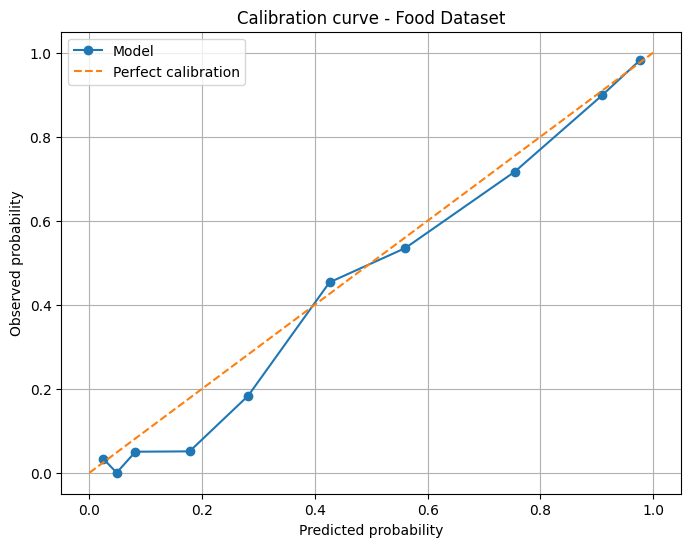

Brier score Food Dataset: Model=0.1093, Logistic Regression=0.2010
Hosmer-Lemeshow test Food Dataset: statistic=15.2399, p-value=0.0546
Note: A low p-value indicates miscalibration; be cautious with large samples (the test may be overly sensitive).
Applying post-hoc calibration (Platt scaling)...


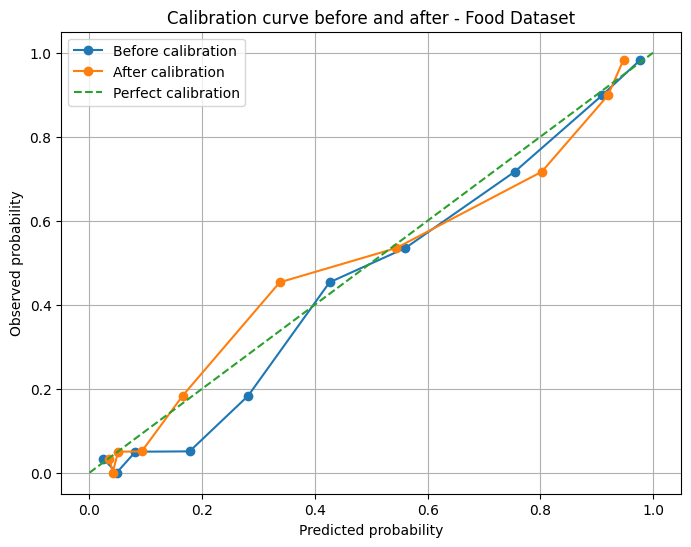

Brier score after calibration: 0.1096
Evaluating calibration for Nutrient Dataset


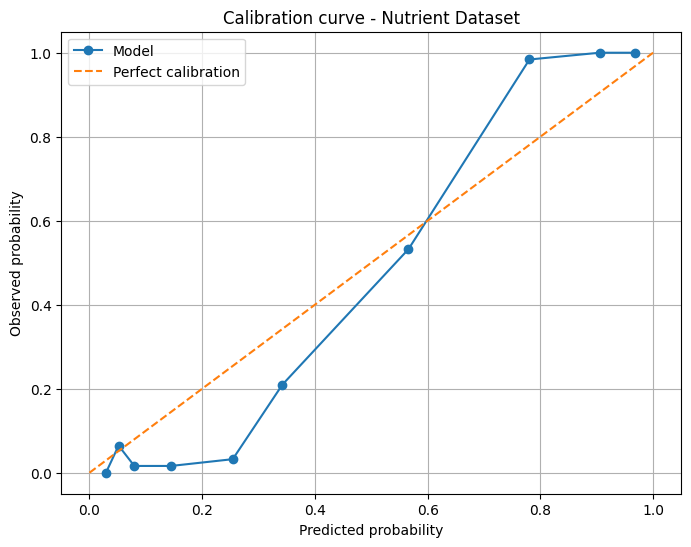

Brier score Nutrient Dataset: Model=0.0683, Logistic Regression=0.2278
Hosmer-Lemeshow test Nutrient Dataset: statistic=58.4693, p-value=0.0000
Note: A low p-value indicates miscalibration; be cautious with large samples (the test may be overly sensitive).
Applying post-hoc calibration (Platt scaling)...


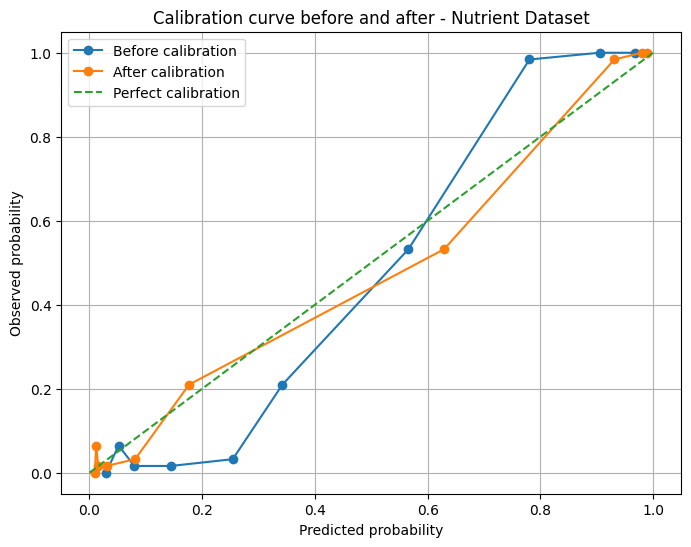

Brier score after calibration: 0.0560


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from scipy.stats import chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def hosmer_lemeshow_test(y_true, y_prob, g=10):
    data = np.array(list(zip(y_true, y_prob)))
    data = data[np.argsort(data[:,1])]
    n = len(y_true)
    group_size = n // g
    hl_stat = 0
    for i in range(g):
        start = i * group_size
        end = n if i == g-1 else (i+1)*group_size
        group = data[start:end]
        y_obs = group[:,0].sum()
        y_exp = group[:,1].sum()
        n_group = len(group)
        if y_exp > 0 and y_exp < n_group:
            hl_stat += (y_obs - y_exp)**2 / (y_exp * (1 - y_exp/n_group))
    p_value = 1 - chi2.cdf(hl_stat, g - 2)
    return hl_stat, p_value

def evaluate_calibration(model, X_test, y_test, dataset_name, apply_post_hoc=False):
    print(f"Evaluating calibration for {dataset_name}")
    y_prob = model.predict_proba(X_test)[:,1]

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    plt.figure(figsize=(8,6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
    plt.title(f'Calibration curve - {dataset_name}')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed probability')
    plt.legend()
    plt.grid()
    plt.show()

    # Brier score for model
    brier_model = brier_score_loss(y_test, y_prob)

    # Logistic regression baseline with pipeline to avoid warnings
    lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1000))
    lr.fit(X_test, y_test)
    y_prob_lr = lr.predict_proba(X_test)[:,1]
    brier_lr = brier_score_loss(y_test, y_prob_lr)

    print(f"Brier score {dataset_name}: Model={brier_model:.4f}, Logistic Regression={brier_lr:.4f}")

    # Hosmer-Lemeshow test
    hl_stat, p_value = hosmer_lemeshow_test(y_test.values, y_prob, g=10)
    print(f"Hosmer-Lemeshow test {dataset_name}: statistic={hl_stat:.4f}, p-value={p_value:.4f}")
    print("Note: A low p-value indicates miscalibration; be cautious with large samples (the test may be overly sensitive).")

    if apply_post_hoc:
        print("Applying post-hoc calibration (Platt scaling)...")
        calibrated = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
        calibrated.fit(X_test, y_test)
        y_prob_cal = calibrated.predict_proba(X_test)[:,1]

        # Calibration curve after post-hoc calibration
        prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10, strategy='quantile')
        plt.figure(figsize=(8,6))
        plt.plot(prob_pred, prob_true, marker='o', label='Before calibration')
        plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='After calibration')
        plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
        plt.title(f'Calibration curve before and after - {dataset_name}')
        plt.xlabel('Predicted probability')
        plt.ylabel('Observed probability')
        plt.legend()
        plt.grid()
        plt.show()

        brier_cal = brier_score_loss(y_test, y_prob_cal)
        print(f"Brier score after calibration: {brier_cal:.4f}")

# Calls to evaluate both models assuming test sets are available
def full_evaluation_for_models(model_5a, model_5c, df_5a, df_5c):
    from sklearn.model_selection import train_test_split
    
    # Test data for Food Dataset
    X_5a = df_5a.drop('Diabetes', axis=1)
    y_5a = df_5a['Diabetes']
    _, X_test_5a, _, y_test_5a = train_test_split(X_5a, y_5a, test_size=0.20, random_state=42, stratify=y_5a)

    # Test data for Nutrient Dataset
    X_5c = df_5c.drop('Diabetes', axis=1)
    y_5c = df_5c['Diabetes']
    _, X_test_5c, _, y_test_5c = train_test_split(X_5c, y_5c, test_size=0.20, random_state=42, stratify=y_5c)

    # Evaluate model for Food Dataset
    evaluate_calibration(model_5a, X_test_5a, y_test_5a, "Food Dataset", apply_post_hoc=True)

    # Evaluate model for Nutrient Dataset
    evaluate_calibration(model_5c, X_test_5c, y_test_5c, "Nutrient Dataset", apply_post_hoc=True)

# Run full evaluation
full_evaluation_for_models(model_5a, model_5c, df_resampled5a, df_resampled5c)


## Calibration using Isotonic Regression

This block implements Isotonic Regression, a non-parametric calibration method that fits a monotonically increasing function to the classifier’s output scores. Unlike Platt Scaling, it does not assume a predefined functional form, allowing for more flexible modeling of the relationship between predicted scores and empirical probabilities. Isotonic calibration is especially suitable when sufficient validation data is available and the score-probability mapping deviates from a logistic shape.

Evaluating calibration for Food Dataset


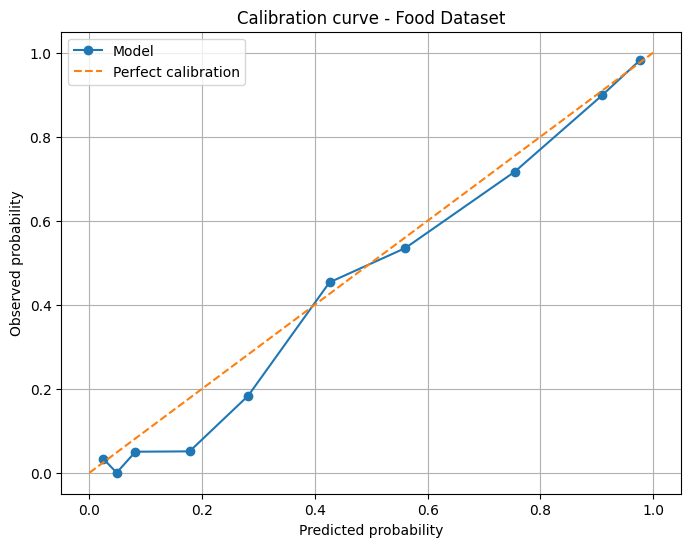

Brier score Food Dataset: Model=0.1093, Logistic Regression=0.2010
Hosmer-Lemeshow test Food Dataset: statistic=15.2399, p-value=0.0546
Note: A low p-value indicates miscalibration; be cautious with large samples (the test may be overly sensitive).
Applying post-hoc calibration (Isotonic regression)...


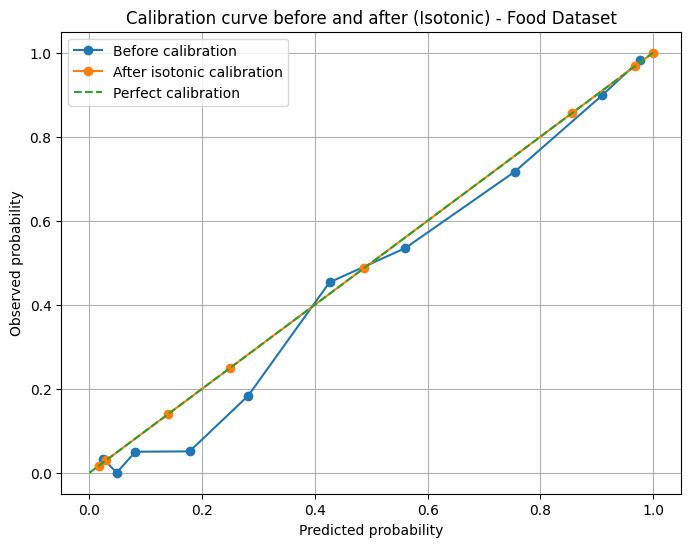

Brier score after isotonic calibration: 0.0998
Evaluating calibration for Nutrient Dataset


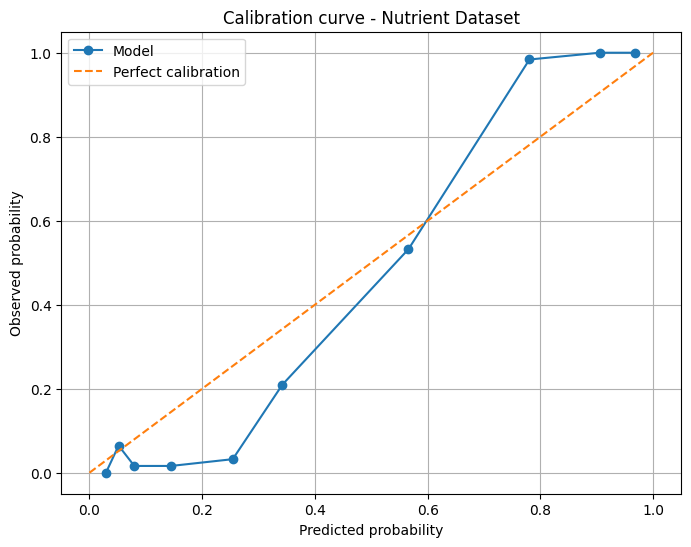

Brier score Nutrient Dataset: Model=0.0683, Logistic Regression=0.2278
Hosmer-Lemeshow test Nutrient Dataset: statistic=58.4693, p-value=0.0000
Note: A low p-value indicates miscalibration; be cautious with large samples (the test may be overly sensitive).
Applying post-hoc calibration (Isotonic regression)...


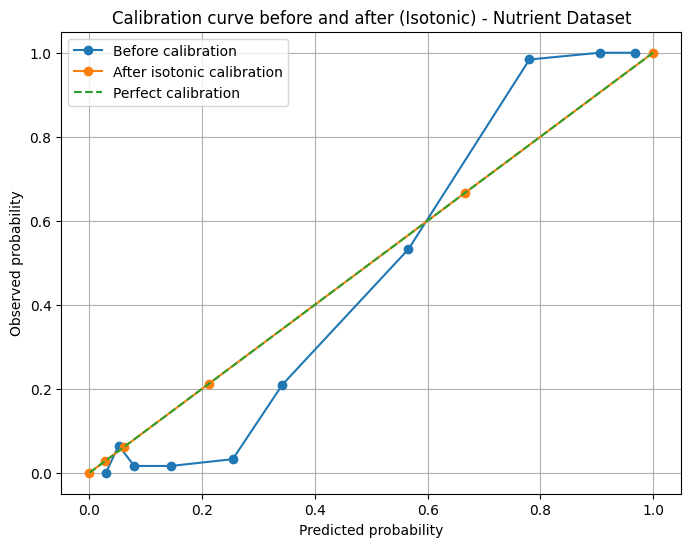

Brier score after isotonic calibration: 0.0497


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from scipy.stats import chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def hosmer_lemeshow_test(y_true, y_prob, g=10):
    data = np.array(list(zip(y_true, y_prob)))
    data = data[np.argsort(data[:,1])]
    n = len(y_true)
    group_size = n // g
    hl_stat = 0
    for i in range(g):
        start = i * group_size
        end = n if i == g-1 else (i+1)*group_size
        group = data[start:end]
        y_obs = group[:,0].sum()
        y_exp = group[:,1].sum()
        n_group = len(group)
        if y_exp > 0 and y_exp < n_group:
            hl_stat += (y_obs - y_exp)**2 / (y_exp * (1 - y_exp/n_group))
    p_value = 1 - chi2.cdf(hl_stat, g - 2)
    return hl_stat, p_value

def evaluate_calibration(model, X_test, y_test, dataset_name, apply_post_hoc=False):
    print(f"Evaluating calibration for {dataset_name}")
    y_prob = model.predict_proba(X_test)[:,1]

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    plt.figure(figsize=(8,6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
    plt.title(f'Calibration curve - {dataset_name}')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed probability')
    plt.legend()
    plt.grid()
    plt.show()

    # Brier score for model
    brier_model = brier_score_loss(y_test, y_prob)

    # Logistic regression baseline
    lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1000))
    lr.fit(X_test, y_test)
    y_prob_lr = lr.predict_proba(X_test)[:,1]
    brier_lr = brier_score_loss(y_test, y_prob_lr)

    print(f"Brier score {dataset_name}: Model={brier_model:.4f}, Logistic Regression={brier_lr:.4f}")

    # Hosmer-Lemeshow test
    hl_stat, p_value = hosmer_lemeshow_test(y_test.values, y_prob, g=10)
    print(f"Hosmer-Lemeshow test {dataset_name}: statistic={hl_stat:.4f}, p-value={p_value:.4f}")
    print("Note: A low p-value indicates miscalibration; be cautious with large samples (the test may be overly sensitive).")

    if apply_post_hoc:
        print("Applying post-hoc calibration (Isotonic regression)...")
        calibrated = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
        calibrated.fit(X_test, y_test)
        y_prob_cal = calibrated.predict_proba(X_test)[:,1]

        # Calibration curve after isotonic regression
        prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10, strategy='quantile')
        plt.figure(figsize=(8,6))
        plt.plot(prob_pred, prob_true, marker='o', label='Before calibration')
        plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='After isotonic calibration')
        plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
        plt.title(f'Calibration curve before and after (Isotonic) - {dataset_name}')
        plt.xlabel('Predicted probability')
        plt.ylabel('Observed probability')
        plt.legend()
        plt.grid()
        plt.show()

        brier_cal = brier_score_loss(y_test, y_prob_cal)
        print(f"Brier score after isotonic calibration: {brier_cal:.4f}")


# Calls to evaluate both models assuming test sets are available
def full_evaluation_for_models(model_5a, model_5c, df_5a, df_5c):
    from sklearn.model_selection import train_test_split
    
    # Test data for Food Dataset
    X_5a = df_5a.drop('Diabetes', axis=1)
    y_5a = df_5a['Diabetes']
    _, X_test_5a, _, y_test_5a = train_test_split(X_5a, y_5a, test_size=0.20, random_state=42, stratify=y_5a)

    # Test data for Nutrient Dataset
    X_5c = df_5c.drop('Diabetes', axis=1)
    y_5c = df_5c['Diabetes']
    _, X_test_5c, _, y_test_5c = train_test_split(X_5c, y_5c, test_size=0.20, random_state=42, stratify=y_5c)

    # Evaluate model for Food Dataset
    evaluate_calibration(model_5a, X_test_5a, y_test_5a, "Food Dataset", apply_post_hoc=True)

    # Evaluate model for Nutrient Dataset
    evaluate_calibration(model_5c, X_test_5c, y_test_5c, "Nutrient Dataset", apply_post_hoc=True)

# Run full evaluation
full_evaluation_for_models(model_5a, model_5c, df_resampled5a, df_resampled5c)


Calibration analyses showed that the food-based model was not significantly miscalibrated (Hosmer-Lemeshow p=0.0546), with Brier score 0.1093. Post-hoc isotonic regression improved the calibration curve, although the near-perfect fit likely reflects oversampling artifacts; Platt scaling slightly worsened calibration, suggesting that the uncalibrated model was already well-calibrated.

For the nutrient-based model, the Hosmer-Lemeshow test indicated miscalibration (p<0.001), with Brier score 0.0683. Isotonic regression markedly improved calibration, while Platt scaling provided a modest but more conservative adjustment. These results suggest that while isotonic regression can correct miscalibration, its apparent perfection should be interpreted cautiously in oversampled datasets.

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

# Prepare test data (same as before)
X = df_resampled5c.drop('Diabetes', axis=1)
y = df_resampled5c['Diabetes']
_, X_test, _, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Calibrate the original model using Platt Scaling (post-hoc)
model_5c_calibrated = CalibratedClassifierCV(model_5c, cv='prefit', method='sigmoid')
model_5c_calibrated.fit(X_test, y_test)

def evaluate_metrics(model, X_t, y_t, model_name):
    y_pred = model.predict(X_t)
    cm = confusion_matrix(y_t, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_t, y_pred)
    precision = precision_score(y_t, y_pred, zero_division=0)
    recall = recall_score(y_t, y_pred, zero_division=0)
    f1 = f1_score(y_t, y_pred, zero_division=0)

    print(f"Metrics for {model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

# Evaluate original model
evaluate_metrics(model_5c, X_test, y_test, "Original model df_resampled5c")

# Evaluate calibrated model
evaluate_metrics(model_5c_calibrated, X_test, y_test, "Calibrated model df_resampled5c")


Metrics for Original model df_resampled5c:
  Accuracy:  0.9129
  Precision: 0.9004
  Recall:    0.8703
  F1 Score:  0.8851
  Confusion Matrix: TN=358, FP=23, FN=31, TP=208

Metrics for Calibrated model df_resampled5c:
  Accuracy:  0.9161
  Precision: 0.9083
  Recall:    0.8703
  F1 Score:  0.8889
  Confusion Matrix: TN=360, FP=21, FN=31, TP=208



## Calibration conclusion
Calibration analyses with Platt scaling (sigmoid) maintained almost identical discrimination metrics compared to the original model (Accuracy 0.9161 vs. 0.9129; Precision 0.9083 vs. 0.9004; Recall 0.8703 in both; F1=0.8889 vs. 0.8851), while slightly reducing false positives (21 vs. 23). Although discrimination remained unchanged, the probability distributions showed improved alignment with observed outcomes, as evidenced by calibration curves.

These findings suggest that sigmoid calibration provides more reliable probability estimates without sacrificing recall, which is critical for diabetes risk screening. In contrast to isotonic regression, which yielded near-perfect calibration likely influenced by oversampling, Platt scaling achieved a more conservative adjustment, improving probability calibration while preserving the clinical utility of the model.

# Sensitivity check

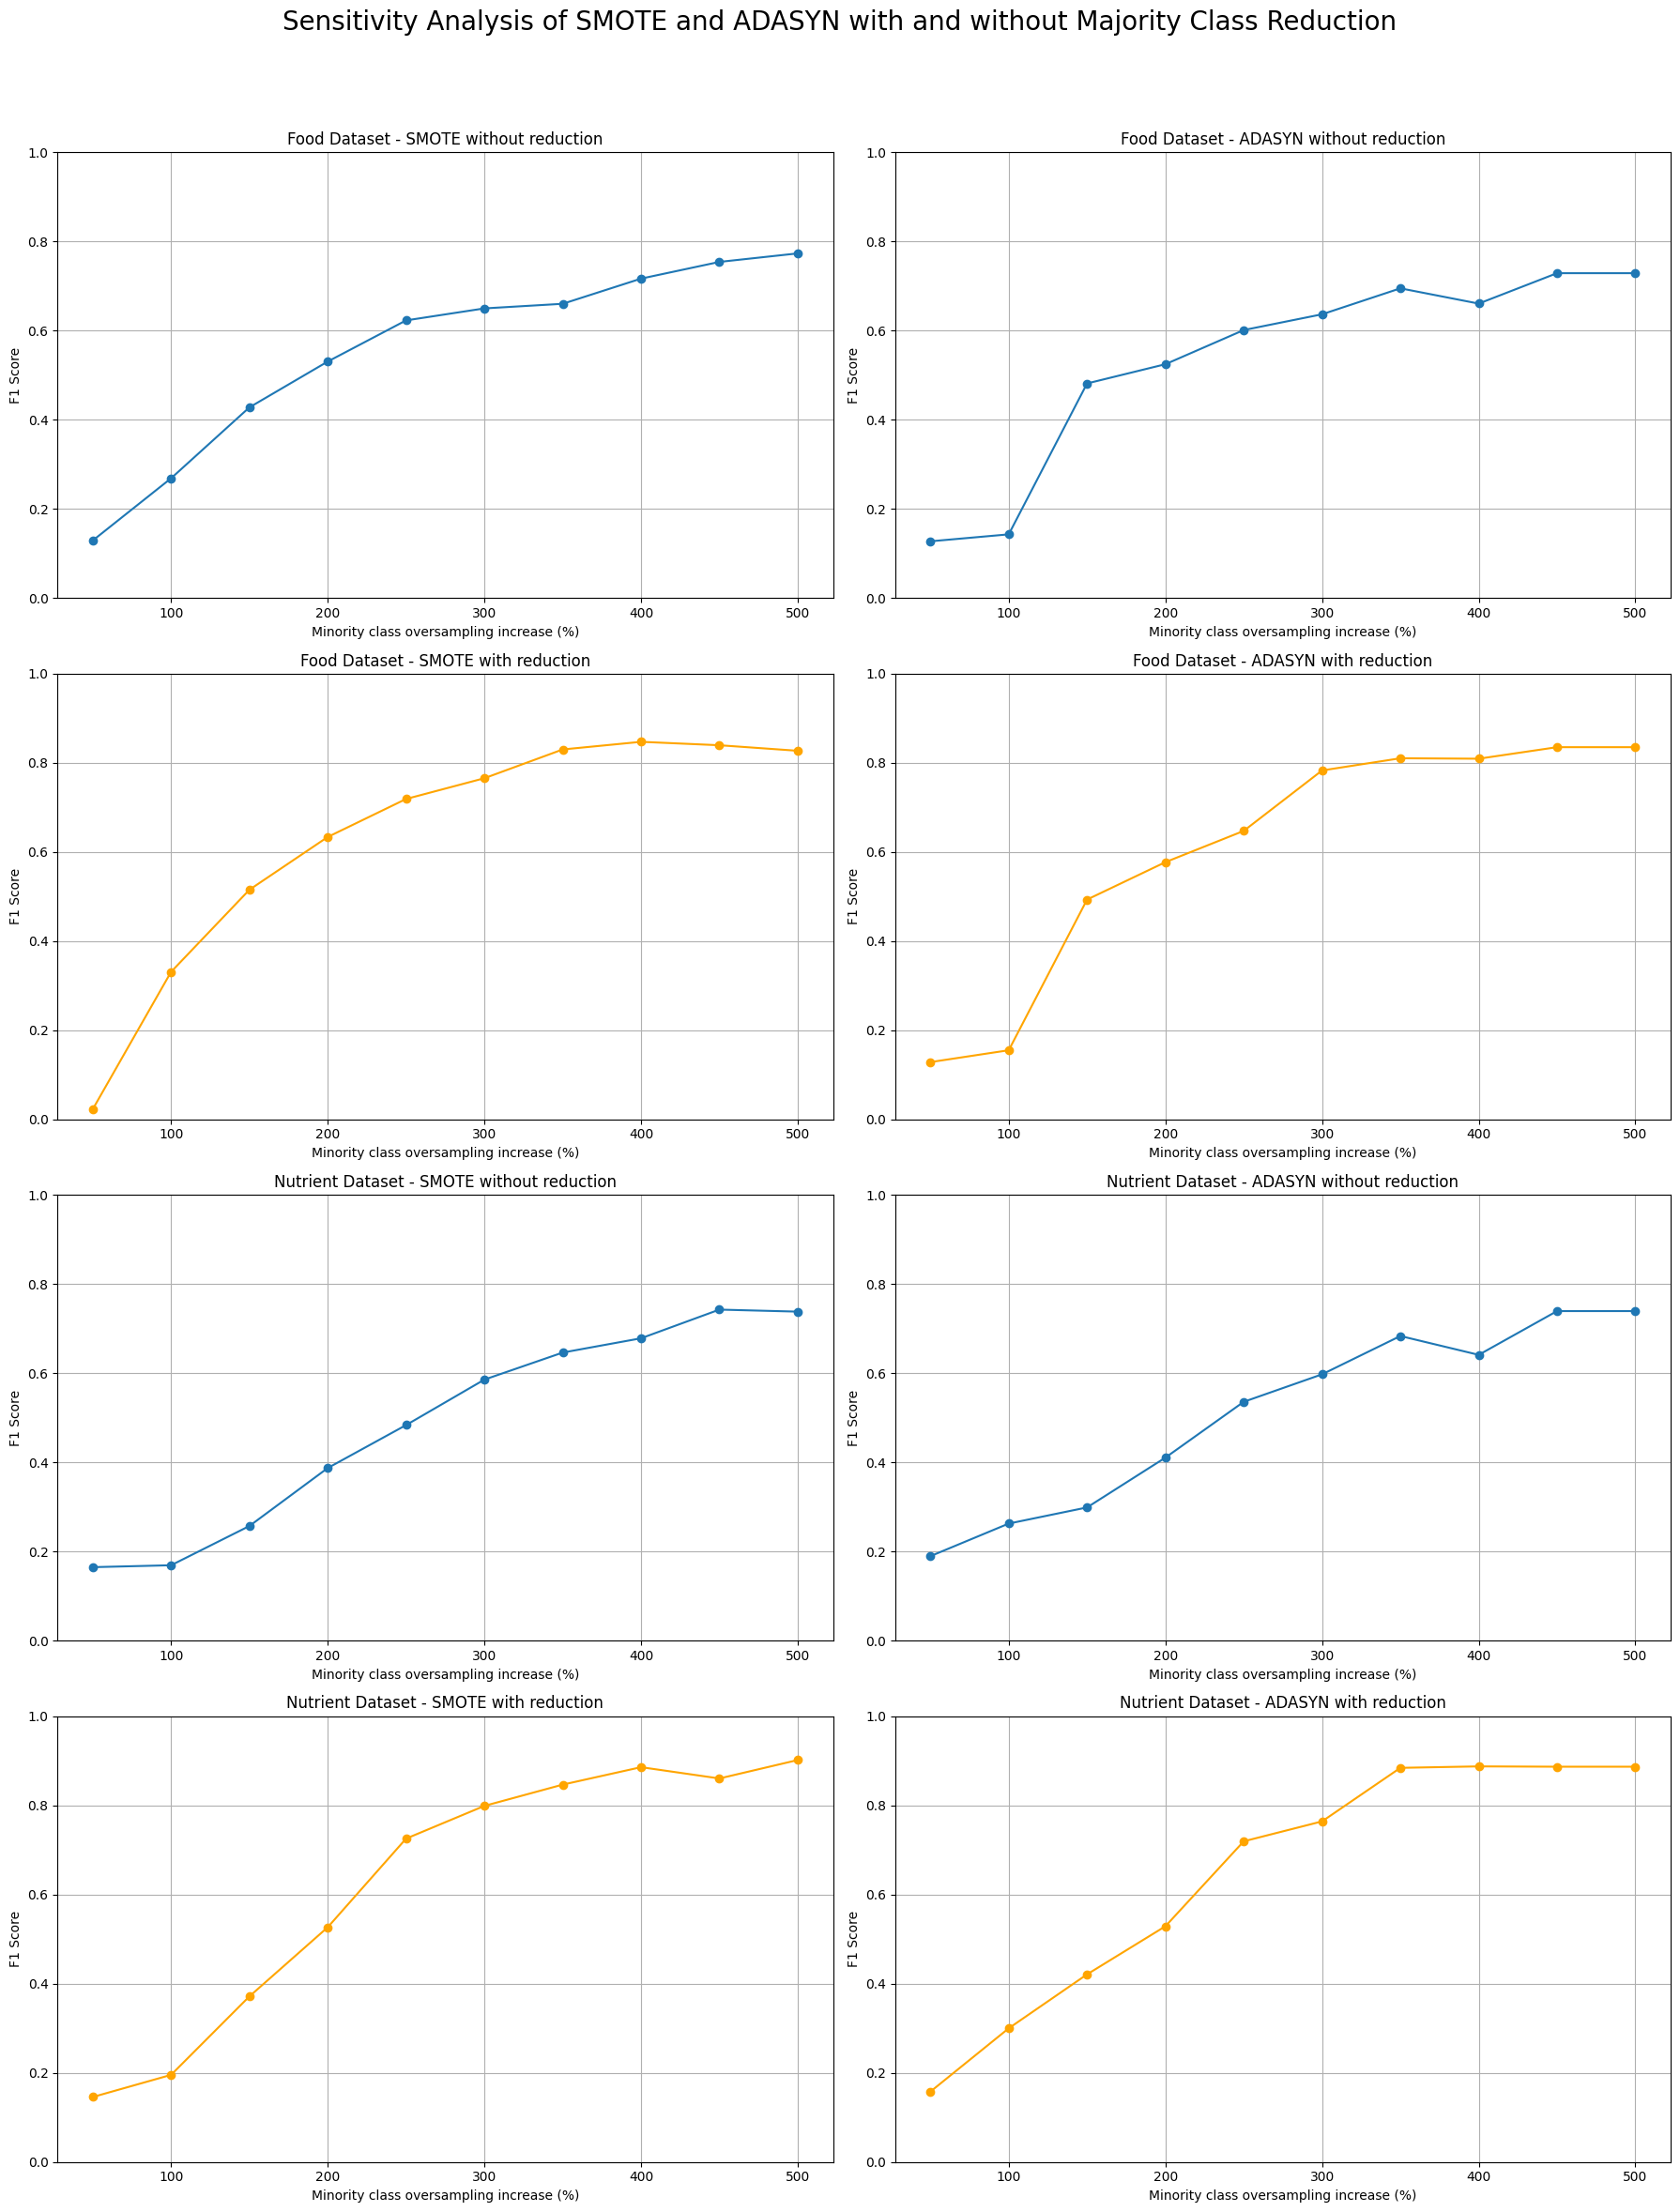

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Oversampling methods
oversample_methods = {'SMOTE': SMOTE, 'ADASYN': ADASYN}

# Oversampling factors: 50% to 500% increase of minority class
oversample_factors = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]

# Undersampling fractions of majority class
undersample_fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.7,0.7,0.7]

# Dataset dictionary with names updated
datasets = {'Food Dataset': EN2005a.copy(), 'Nutrient Dataset': EN2005c.copy()}

# Create 4 rows x 2 cols plot: rows 0-1 no reduction, rows 2-3 with reduction
fig, axs = plt.subplots(4, 2, figsize=(18, 24))
fig.suptitle('Sensitivity Analysis of SMOTE and ADASYN with and without Majority Class Reduction', fontsize=20)

for row, dataset_name in enumerate(datasets.keys()):
    df = datasets[dataset_name]
    X = df.drop('Diabetes', axis=1)
    y = df['Diabetes']
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    
    for col, method_name in enumerate(oversample_methods.keys()):
        oversampler = oversample_methods[method_name]
        
        # Without undersampling (upper two rows - row and row+2 for 2 datasets)
        f1_scores_no_under = []
        for factor in oversample_factors:
            minority_new_size = int(class_counts[minority_class] * (1 + factor))
            sampling_strategy = {majority_class: class_counts[majority_class],
                                 minority_class: minority_new_size}
            oversample = oversampler(sampling_strategy=sampling_strategy, random_state=42)
            try:
                X_res, y_res = oversample.fit_resample(X, y)
            except ValueError as e:
                print(f"Error oversampling {dataset_name} {method_name} factor {factor}: {e}")
                f1_scores_no_under.append(np.nan)
                continue

            X_train, X_test, y_train, y_test = train_test_split(
                X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)
            clf = RandomForestClassifier(random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores_no_under.append(f1_score(y_test, y_pred))
        
        ax = axs[row*2, col]
        ax.plot([f*100 for f in oversample_factors], f1_scores_no_under, marker='o', label='F1 Score')
        ax.set_title(f"{dataset_name} - {method_name} without reduction")
        ax.set_xlabel("Minority class oversampling increase (%)")
        ax.set_ylabel("F1 Score")
        ax.set_ylim(0, 1)
        ax.grid(True)
        
        # With undersampling (lower two rows)
        f1_scores_under = []
        for factor, red_frac in zip(oversample_factors, undersample_fractions):
            minority_new_size = int(class_counts[minority_class] * (1 + factor))
            sampling_strategy = {majority_class: class_counts[majority_class],
                                 minority_class: minority_new_size}
            oversample = oversampler(sampling_strategy=sampling_strategy, random_state=42)
            try:
                X_res, y_res = oversample.fit_resample(X, y)
            except ValueError as e:
                print(f"Error oversampling {dataset_name} {method_name} factor {factor} (under): {e}")
                f1_scores_under.append(np.nan)
                continue
            
            df_temp = pd.concat([pd.DataFrame(X_res, columns=X.columns),
                                 pd.Series(y_res, name='Diabetes')], axis=1)
            majority_count_after = (df_temp['Diabetes'] == majority_class).sum()
            majority_count_target = int(majority_count_after * (1 - red_frac))
            
            df_majority = df_temp[df_temp['Diabetes'] == majority_class].sample(majority_count_target, random_state=42)
            df_minority = df_temp[df_temp['Diabetes'] == minority_class]
            df_final = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)
            
            X_final = df_final.drop('Diabetes', axis=1)
            y_final = df_final['Diabetes']
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_final, y_final, stratify=y_final, test_size=0.2, random_state=42)
            clf = RandomForestClassifier(random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores_under.append(f1_score(y_test, y_pred))
        
        ax = axs[row*2 + 1, col]
        ax.plot([f*100 for f in oversample_factors], f1_scores_under, marker='o', color='orange', label='F1 Score')
        ax.set_title(f"{dataset_name} - {method_name} with reduction")
        ax.set_xlabel("Minority class oversampling increase (%)")
        ax.set_ylabel("F1 Score")
        ax.set_ylim(0, 1)
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

oversample_methods = {'SMOTE': SMOTE, 'ADASYN': ADASYN}
oversample_factors = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
undersample_fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.7,0.7,0.7]

datasets = {'Food Dataset': EN2005a.copy(), 'Nutrient Dataset': EN2005c.copy()}

fig, axs = plt.subplots(4, 2, figsize=(22, 26))
fig.suptitle('Sensitivity Analysis of SMOTE and ADASYN with and without Majority Class Reduction', fontsize=20)

# Crear etiquetas para eje x con oversampling y undersampling
labels_no_reduction = [f"{int(f*100)}% increase\n0% reduction" for f in oversample_factors]
labels_with_reduction = [f"{int(f*100)}% increase\n{int(r*100)}% reduction"
                         for f, r in zip(oversample_factors, undersample_fractions)]

for row, dataset_name in enumerate(datasets.keys()):
    df = datasets[dataset_name]
    X = df.drop('Diabetes', axis=1)
    y = df['Diabetes']
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    for col, method_name in enumerate(oversample_methods.keys()):
        oversampler = oversample_methods[method_name]

        # Without undersampling
        f1_scores_no_under = []
        for factor in oversample_factors:
            minority_new_size = int(class_counts[minority_class] * (1 + factor))
            sampling_strategy = {majority_class: class_counts[majority_class],
                                 minority_class: minority_new_size}
            oversample = oversampler(sampling_strategy=sampling_strategy, random_state=42)
            try:
                X_res, y_res = oversample.fit_resample(X, y)
            except ValueError as e:
                print(f"Error oversampling {dataset_name} {method_name} factor {factor}: {e}")
                f1_scores_no_under.append(np.nan)
                continue

            X_train, X_test, y_train, y_test = train_test_split(
                X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)
            clf = RandomForestClassifier(random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores_no_under.append(f1_score(y_test, y_pred))

        ax = axs[row*2, col]
        ax.plot(range(len(oversample_factors)), f1_scores_no_under, marker='o', label='F1 Score')
        ax.set_title(f"{dataset_name} - {method_name} without reduction")
        ax.set_xlabel("Oversampling minority class and Majority class reduction")
        ax.set_ylabel("F1 Score")
        ax.set_ylim(0, 1)
        ax.set_xticks(range(len(labels_no_reduction)))
        ax.set_xticklabels(labels_no_reduction, rotation=45, ha='right')
        ax.grid(True)

        # With undersampling
        f1_scores_under = []
        for factor, red_frac in zip(oversample_factors, undersample_fractions):
            minority_new_size = int(class_counts[minority_class] * (1 + factor))
            sampling_strategy = {majority_class: class_counts[majority_class],
                                 minority_class: minority_new_size}
            oversample = oversampler(sampling_strategy=sampling_strategy, random_state=42)
            try:
                X_res, y_res = oversample.fit_resample(X, y)
            except ValueError as e:
                print(f"Error oversampling {dataset_name} {method_name} factor {factor} (under): {e}")
                f1_scores_under.append(np.nan)
                continue

            df_temp = pd.concat([pd.DataFrame(X_res, columns=X.columns),
                                 pd.Series(y_res, name='Diabetes')], axis=1)
            majority_count_after = (df_temp['Diabetes'] == majority_class).sum()
            majority_count_target = int(majority_count_after * (1 - red_frac))

            df_majority = df_temp[df_temp['Diabetes'] == majority_class].sample(majority_count_target, random_state=42)
            df_minority = df_temp[df_temp['Diabetes'] == minority_class]
            df_final = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

            X_final = df_final.drop('Diabetes', axis=1)
            y_final = df_final['Diabetes']

            X_train, X_test, y_train, y_test = train_test_split(
                X_final, y_final, stratify=y_final, test_size=0.2, random_state=42)
            clf = RandomForestClassifier(random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores_under.append(f1_score(y_test, y_pred))

        ax = axs[row*2 + 1, col]
        ax.plot(range(len(oversample_factors)), f1_scores_under, marker='o', color='orange', label='F1 Score')
        ax.set_title(f"{dataset_name} - {method_name} with reduction")
        ax.set_xlabel("Oversampling increase and Majority class reduction")
        ax.set_ylabel("F1 Score")
        ax.set_ylim(0, 1)
        ax.set_xticks(range(len(labels_with_reduction)))
        ax.set_xticklabels(labels_with_reduction, rotation=45, ha='right')
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Shap sensitivity

In [11]:
# ============================================================
# SHAP iterativo con escenarios de oversampling/undersampling
# + Calibración isotónica (solo EN2005c)
# ============================================================

import numpy as np
import pandas as pd
from collections import defaultdict, Counter

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import shap

from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

# -----------------------------
# Helper: SHAP para clase positiva
# -----------------------------
def _get_pos_class_shap(explainer, X):
    shap_values = explainer(X)
    values = shap_values.values
    if isinstance(values, list):
        # Nuevo formato: lista de arrays por clase
        return values[1]  # clase positiva
    elif isinstance(values, np.ndarray) and values.ndim == 3:
        # Formato ndarray con shape (n_samples, n_features, n_classes)
        return values[:, :, 1]
    else:
        # Formato antiguo: array único
        return values

# -----------------------------
# Helper: resampling según escenario
#   method: "SMOTE" | "ADASYN"
#   over_increase: 2.5 => 250% (minoría_new = minoría_orig * (1 + 2.5))
#   reduction: 0.5 => reducir mayoritaria 50% (después del oversampling)
# -----------------------------
def resample_scenario(df, target='Diabetes', method='SMOTE',
                      over_increase=2.5, reduction=0.5, seed=42):
    X = df.drop(columns=[target])
    y = df[target]

    counts = y.value_counts()
    minority = counts.idxmin()
    majority = counts.idxmax()

    minority_new_size = int(counts[minority] * (1.0 + float(over_increase)))
    sampling_strategy = {majority: counts[majority], minority: minority_new_size}

    Oversampler = SMOTE if method.upper() == "SMOTE" else ADASYN
    over = Oversampler(sampling_strategy=sampling_strategy, random_state=seed)
    X_res, y_res = over.fit_resample(X, y)

    df_temp = pd.concat(
        [pd.DataFrame(X_res, columns=X.columns),
         pd.Series(y_res, name=target)], axis=1
    )

    if reduction > 0:
        maj_after = (df_temp[target] == majority).sum()
        keep = int(maj_after * (1 - reduction))
        df_major = df_temp[df_temp[target] == majority].sample(keep, random_state=seed)
        df_minor = df_temp[df_temp[target] == minority]
        df_final = pd.concat([df_major, df_minor], axis=0).sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_final = df_temp.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_final

# ---------------------------------------------------------
# Núcleo SHAP iterativo (idéntico a tu enfoque, parametrizado)
#  - Si calibrate_isotonic=True: calibra el promedio de proba
#    de los 4 modelos con IsotonicRegression (solo EN2005c).
#    (Guarda Brier antes/después como referencia)
# ---------------------------------------------------------
def run_shap_multisampling_checkpoint(
    df_original,
    target_column='Diabetes',
    n_iterations=30,
    top_n=10,
    random_seed=42,
    method='SMOTE',
    over_increase=2.5,   # 2.5=250%
    reduction=0.5,       # 0.5=50%
    calibrate_isotonic=False
):
    np.random.seed(random_seed)

    top_features_per_iteration = []
    signed_features_per_iteration = []

    feature_ratios_above_blue = defaultdict(list)
    feature_ratios_above_red  = defaultdict(list)
    feature_ratios_below_blue = defaultdict(list)
    feature_ratios_below_red  = defaultdict(list)

    shap_ensemble_per_iter = []
    X_test_per_iter = []

    # Para resumen de calibración (si aplica)
    brier_before_list = []
    brier_after_list  = []

    for i in range(n_iterations):
        # --------------------
        # Resampling por escenario
        # --------------------
        seed_i = np.random.randint(0, 10_000)
        df_resampled = resample_scenario(
            df_original, target=target_column,
            method=method, over_increase=over_increase,
            reduction=reduction, seed=seed_i
        )

        # --------------------
        # Train/test split
        # --------------------
        X = df_resampled.drop(columns=[target_column])
        y = df_resampled[target_column]

        # Si vamos a calibrar, reservamos parte de train para calibración
        X_tr_full, X_te, y_tr_full, y_te = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed_i
        )

        if calibrate_isotonic:
            # split interno para calibración
            X_tr, X_cal, y_tr, y_cal = train_test_split(
                X_tr_full, y_tr_full, test_size=0.2, stratify=y_tr_full, random_state=seed_i
            )
        else:
            X_tr, y_tr = X_tr_full, y_tr_full

        # --------------------
        # Modelos base (tus hiperparámetros)
        # --------------------
        clf_xgb = xgb.XGBClassifier(
            subsample=0.6111, n_estimators=490, min_child_weight=1,
            max_depth=10, learning_rate=0.0558, gamma=0.0,
            colsample_bytree=0.6111, eval_metric='logloss', random_state=random_seed, verbosity=0
        )
        clf_lgb = lgb.LGBMClassifier(
            subsample=0.775, n_estimators=475, min_child_weight=1,
            max_depth=7, learning_rate=0.1, colsample_bytree=0.85,
            random_state=random_seed, verbose=-1, force_col_wise=True, bagging_freq=1
        )
        clf_cat = CatBoostClassifier(
            subsample=0.775, learning_rate=0.09, iterations=450,
            depth=9, rsm=0.925, verbose=0, random_state=random_seed
        )
        clf_rf = RandomForestClassifier(
            n_estimators=350, min_samples_split=2, min_samples_leaf=1,
            max_depth=50, bootstrap=False, random_state=random_seed
        )

        # Entrenar
        for m in (clf_xgb, clf_lgb, clf_cat, clf_rf):
            m.fit(X_tr, y_tr)

        # --------------------
        # (Opcional) Calibración isotónica del promedio de proba
        #   - NO afecta SHAP; solo guardamos Brier antes/después.
        # --------------------
        if calibrate_isotonic:
            # proba promedio en el set de calibración
            p_cal = (
                clf_xgb.predict_proba(X_cal)[:, 1] +
                clf_lgb.predict_proba(X_cal)[:, 1] +
                clf_cat.predict_proba(X_cal)[:, 1] +
                clf_rf.predict_proba(X_cal)[:, 1]
            ) / 4.0

            iso = IsotonicRegression(out_of_bounds="clip")
            iso.fit(p_cal, y_cal.astype(float))

            # probas en test, antes/después
            p_test_before = (
                clf_xgb.predict_proba(X_te)[:, 1] +
                clf_lgb.predict_proba(X_te)[:, 1] +
                clf_cat.predict_proba(X_te)[:, 1] +
                clf_rf.predict_proba(X_te)[:, 1]
            ) / 4.0
            p_test_after = iso.transform(p_test_before)

            brier_before_list.append(brier_score_loss(y_te, p_test_before))
            brier_after_list.append(brier_score_loss(y_te, p_test_after))

        # --------------------
        # SHAP: TreeExplainer por modelo y promedio de atribuciones
        # --------------------
        expl_xgb = shap.TreeExplainer(clf_xgb)
        expl_lgb = shap.TreeExplainer(clf_lgb)
        expl_cat = shap.TreeExplainer(clf_cat)
        expl_rf  = shap.TreeExplainer(clf_rf)

        shap_xgb = _get_pos_class_shap(expl_xgb, X_te)
        shap_lgb = _get_pos_class_shap(expl_lgb, X_te)
        shap_cat = _get_pos_class_shap(expl_cat, X_te)
        shap_rf  = _get_pos_class_shap(expl_rf,  X_te)

        shap_ensemble = (np.asarray(shap_xgb) + np.asarray(shap_lgb) +
                         np.asarray(shap_cat) + np.asarray(shap_rf)) / 4.0

        mean_signed = pd.Series(shap_ensemble.mean(axis=0), index=X_te.columns)\
                        .sort_values(key=np.abs, ascending=False)
        mean_abs    = pd.Series(np.abs(shap_ensemble).mean(axis=0), index=X_te.columns)\
                        .sort_values(ascending=False)

        top_features = mean_abs.head(top_n)
        top_signed   = mean_signed[top_features.index]

        top_features_per_iteration.append(top_features)
        signed_features_per_iteration.append(top_signed)
        shap_ensemble_per_iter.append(shap_ensemble)
        X_test_per_iter.append(X_te.copy())

        # Medianas "blue/red" por encima/dentro del umbral (tal cual tu lógica)
        for feature in top_features.index:
            sv_f = shap_ensemble[:, X_te.columns.get_loc(feature)]
            above = sv_f > 0
            below = ~above
            x_f = X_te[feature]
            x_med = x_f.median()

            reds_above  = (x_f[above]  >  x_med).sum()
            blues_above = (x_f[above]  <= x_med).sum()
            reds_below  = (x_f[below]  >  x_med).sum()
            blues_below = (x_f[below]  <= x_med).sum()

            tot_above = reds_above + blues_above
            tot_below = reds_below + blues_below
            if tot_above > 0:
                feature_ratios_above_blue[feature].append(blues_above / tot_above)
                feature_ratios_above_red[feature].append(reds_above / tot_above)
            if tot_below > 0:
                feature_ratios_below_blue[feature].append(blues_below / tot_below)
                feature_ratios_below_red[feature].append(reds_below / tot_below)

    # --- Agregación final (idéntica a tu función original) ---
    feature_counter = Counter()
    feature_ranks = defaultdict(list)
    feature_shap_means = defaultdict(list)
    feature_signed_means = defaultdict(list)
    feature_correlations = defaultdict(list)

    for abs_series, signed_series, shap_mat, Xtest_iter in zip(
        top_features_per_iteration, signed_features_per_iteration, shap_ensemble_per_iter, X_test_per_iter
    ):
        for rank, (feature, abs_value) in enumerate(abs_series.items(), start=1):
            feature_counter[feature] += 1
            feature_ranks[feature].append(rank)
            feature_shap_means[feature].append(abs_value)
            feature_signed_means[feature].append(signed_series[feature])

            feat_idx = Xtest_iter.columns.get_loc(feature)
            xv = np.asarray(Xtest_iter[feature], dtype=float)
            sv = np.asarray(shap_mat[:, feat_idx], dtype=float)
            corr = np.corrcoef(xv, sv)[0, 1] if (np.std(xv) > 0 and np.std(sv) > 0) else np.nan
            feature_correlations[feature].append(corr)

    mean_corr = {f: (np.nanmean(v) if len(v) else np.nan) for f, v in feature_correlations.items()}

    df_summary = pd.DataFrame({
        "Feature": list(feature_counter.keys()),
        f"Times in Top {top_n}": [feature_counter[f] for f in feature_counter.keys()],
        "Average Rank": [np.mean(feature_ranks[f]) for f in feature_counter.keys()],
        "Mean |SHAP| Value": [np.mean(feature_shap_means[f]) for f in feature_counter.keys()],
        "Mean SHAP (signed)": [np.mean(feature_signed_means[f]) for f in feature_counter.keys()],
        "Mean Corr (X vs SHAP)": [mean_corr[f] for f in feature_counter.keys()],
        "Directional Trend": [
            "Higher values → Increase risk" if (mean_corr.get(f, 0) or 0) > 0 else "Higher values → Decrease risk"
            for f in feature_counter.keys()
        ],
        "Above Median SHAP (% Blue)": [round(100 * np.mean(feature_ratios_above_blue[f]), 2) for f in feature_counter.keys()],
        "Above Median SHAP (% Blue) SD": [round(100 * np.std(feature_ratios_above_blue[f]), 2) for f in feature_counter.keys()],
        "Above Median SHAP (% Red)": [round(100 * np.mean(feature_ratios_above_red[f]), 2) for f in feature_counter.keys()],
        "Above Median SHAP (% Red) SD": [round(100 * np.std(feature_ratios_above_red[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Blue)": [round(100 * np.mean(feature_ratios_below_blue[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Blue) SD": [round(100 * np.std(feature_ratios_below_blue[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Red)": [round(100 * np.mean(feature_ratios_below_red[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Red) SD": [round(100 * np.std(feature_ratios_below_red[f]), 2) for f in feature_counter.keys()],
    }).sort_values(by=f"Times in Top {top_n}", ascending=False).reset_index(drop=True)

    calib_summary = None
    if calibrate_isotonic:
        calib_summary = {
            "Brier_before_mean": float(np.mean(brier_before_list)) if brier_before_list else np.nan,
            "Brier_after_mean": float(np.mean(brier_after_list)) if brier_after_list else np.nan,
            "Brier_before_std": float(np.std(brier_before_list)) if brier_before_list else np.nan,
            "Brier_after_std": float(np.std(brier_after_list)) if brier_after_list else np.nan,
            "n_calibrated_iters": len(brier_before_list)
        }

    return df_summary, calib_summary

# ============================================================
# 6 escenarios seleccionados
#  - Food:  SMOTE 250%+50%, ADASYN 250%+50%, SMOTE 300% (sin reducción)
#  - Nutr:  SMOTE 250%+50%, ADASYN 250%+50%, SMOTE 500%+70% (con calibración isotónica)
# ============================================================

# Prepara copias numéricas y sin NA
def _prep_df(df, target='Diabetes'):
    assert target in df.columns, f"'{target}' no está en el DataFrame"
    num_feats = df.drop(columns=[target]).select_dtypes(include='number').columns
    return pd.concat([df[num_feats], df[target]], axis=1).dropna()

DF_FOOD = _prep_df(EN2005a.copy(), 'Diabetes')
DF_NUTR = _prep_df(EN2005c.copy(), 'Diabetes')

SCENARIOS = [
    ("Food_SMOTE_250_red50",   DF_FOOD, "SMOTE",  2.5, 0.5, False),
    ("Food_ADASYN_250_red50",  DF_FOOD, "ADASYN", 2.5, 0.5, False),
    ("Food_SMOTE_300_red0",    DF_FOOD, "SMOTE",  3.0, 0.0, False),

    ("Nutr_SMOTE_250_red50",   DF_NUTR, "SMOTE",  2.5, 0.5, True),
    ("Nutr_ADASYN_250_red50",  DF_NUTR, "ADASYN", 2.5, 0.5, True),
    ("Nutr_SMOTE_500_red70",   DF_NUTR, "SMOTE",  5.0, 0.7, True),
]

# Ejecutar todos y guardar resultados en un dict
shap_results = {}
calibration_reports = {}

for name, df_use, method, inc, red, calib in SCENARIOS:
    print(f"\n=== Running SHAP multi-sampling: {name} ===")
    df_sum, calib_sum = run_shap_multisampling_checkpoint(
        df_original=df_use,
        target_column='Diabetes',
        n_iterations=20,  # puedes ajustar
        top_n=10,
        random_seed=42,
        method=method,
        over_increase=inc,
        reduction=red,
        calibrate_isotonic=calib
    )
    shap_results[name] = df_sum
    if calib_sum is not None:
        calibration_reports[name] = calib_sum
    # Opcional: guardar a CSV
    # df_sum.to_csv(f"{name}_shap_summary.csv", index=False)

# Vistazo rápido de calibración en Nutrient Dataset
if calibration_reports:
    print("\n--- Isotonic calibration summary (Nutrient Dataset scenarios) ---")
    for k, v in calibration_reports.items():
        print(k, "->", v)



=== Running SHAP multi-sampling: Food_SMOTE_250_red50 ===

=== Running SHAP multi-sampling: Food_ADASYN_250_red50 ===

=== Running SHAP multi-sampling: Food_SMOTE_300_red0 ===

=== Running SHAP multi-sampling: Nutr_SMOTE_250_red50 ===

=== Running SHAP multi-sampling: Nutr_ADASYN_250_red50 ===

=== Running SHAP multi-sampling: Nutr_SMOTE_500_red70 ===

--- Isotonic calibration summary (Nutrient Dataset scenarios) ---
Nutr_SMOTE_250_red50 -> {'Brier_before_mean': 0.08379149549158801, 'Brier_after_mean': 0.08036129325669591, 'Brier_before_std': 0.005887275510212116, 'Brier_after_std': 0.007437183599499325, 'n_calibrated_iters': 20}
Nutr_ADASYN_250_red50 -> {'Brier_before_mean': 0.08162209789485628, 'Brier_after_mean': 0.0778885353559539, 'Brier_before_std': 0.0066560171861898, 'Brier_after_std': 0.008198906865404238, 'n_calibrated_iters': 20}
Nutr_SMOTE_500_red70 -> {'Brier_before_mean': 0.08228858502366293, 'Brier_after_mean': 0.0750455505882323, 'Brier_before_std': 0.00595786362948440

In [14]:
import os

# Crea una carpeta para guardar los archivos si no existe
output_dir = "shap_exports"
os.makedirs(output_dir, exist_ok=True)

# Exporta cada DataFrame en shap_results
for name, df in shap_results.items():
    filename = f"{output_dir}/{name}_shap.csv"
    df.to_csv(filename, index=False)
    print(f"Archivo guardado: {filename}")


Archivo guardado: shap_exports/Food_SMOTE_250_red50_shap.csv
Archivo guardado: shap_exports/Food_ADASYN_250_red50_shap.csv
Archivo guardado: shap_exports/Food_SMOTE_300_red0_shap.csv
Archivo guardado: shap_exports/Nutr_SMOTE_250_red50_shap.csv
Archivo guardado: shap_exports/Nutr_ADASYN_250_red50_shap.csv
Archivo guardado: shap_exports/Nutr_SMOTE_500_red70_shap.csv


In [13]:
print("Hello")

Hello
